# 1.1 Without Filter

In [2]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
    
import matplotlib.pyplot as plt
import numpy as np

In [3]:
GAMMA = 0.99
LR = 1e-4
BATCH_SIZE = 64

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
class ReplayBuffer:
    def __init__(self, capacity=1_000_000):
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, s2, d):
        self.buffer.append((s, a, r, s2, d))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s2, d = map(np.array, zip(*batch))
        return (
            torch.FloatTensor(s).to(device),
            torch.FloatTensor(a).to(device),
            torch.FloatTensor(r).unsqueeze(1).to(device),
            torch.FloatTensor(s2).to(device),
            torch.FloatTensor(d).unsqueeze(1).to(device),
        )
    def __len__(self):
        return len(self.buffer)


In [5]:
LOG_STD_MIN = -20
LOG_STD_MAX = 2

class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
        )
        self.mu = nn.Linear(256, act_dim)
        self.log_std = nn.Linear(256, act_dim)

    def forward(self, state):
        x = self.net(state)
        mu = self.mu(x)
        log_std = torch.clamp(self.log_std(x), LOG_STD_MIN, LOG_STD_MAX)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, state):
        mu, std = self(state)
        dist = torch.distributions.Normal(mu, std)
        z = dist.rsample()
        action = torch.tanh(z)

        log_prob = dist.log_prob(z) - torch.log(1 - action.pow(2) + 1e-6)
        log_prob = log_prob.sum(dim=1, keepdim=True)

        return action, log_prob


In [6]:
class Critic(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward(self, state, action):
        return self.net(torch.cat([state, action], dim=1))


In [7]:
env = gym.make("Pendulum-v1")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_limit = env.action_space.high[0]

actor = Actor(obs_dim, act_dim).to(device)
critic1 = Critic(obs_dim, act_dim).to(device)
critic2 = Critic(obs_dim, act_dim).to(device)
target1 = Critic(obs_dim, act_dim).to(device)
target2 = Critic(obs_dim, act_dim).to(device)

target1.load_state_dict(critic1.state_dict())
target2.load_state_dict(critic2.state_dict())

actor_optim = optim.Adam(actor.parameters(), lr=3e-4)
critic_optim = optim.Adam(
    list(critic1.parameters()) + list(critic2.parameters()), lr=3e-4
)

alpha = 0.2
gamma = 0.99
tau = 0.005

buffer = ReplayBuffer()

In [8]:
print(env.unwrapped.__doc__)



    ## Description

    The inverted pendulum swingup problem is based on the classic problem in control theory.
    The system consists of a pendulum attached at one end to a fixed point, and the other end being free.
    The pendulum starts in a random position and the goal is to apply torque on the free end to swing it
    into an upright position, with its center of gravity right above the fixed point.

    The diagram below specifies the coordinate system used for the implementation of the pendulum's
    dynamic equations.

    ![Pendulum Coordinate System](/_static/diagrams/pendulum.png)

    - `x-y`: cartesian coordinates of the pendulum's end in meters.
    - `theta` : angle in radians.
    - `tau`: torque in `N m`. Defined as positive _counter-clockwise_.

    ## Action Space

    The action is a `ndarray` with shape `(1,)` representing the torque applied to free end of the pendulum.

    | Num | Action | Min  | Max |
    |-----|--------|------|-----|
    | 0   | Torque | -2.

## 1.2 Training

In [9]:
state, _ = env.reset()
episode_rewards_no_hpf = []
current_episode_reward = 0

for step in range(30_000):

    with torch.no_grad():
        s = torch.FloatTensor(state).unsqueeze(0).to(device)
        a, _ = actor.sample(s)
        action = (a * act_limit).cpu().numpy()[0]

    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    current_episode_reward += reward
    
    buffer.push(state, action, reward, next_state, done)
    state = next_state
    
    if done:
        episode_rewards_no_hpf.append(current_episode_reward)
        current_episode_reward = 0
        state, _ = env.reset()

    if len(buffer) < 256:
        continue

    states, actions, rewards, next_states, dones = buffer.sample(256)

    # ----- Critic update -----
    with torch.no_grad():
        next_actions, logp = actor.sample(next_states)
        next_actions = next_actions * act_limit
        q1_t = target1(next_states, next_actions)
        q2_t = target2(next_states, next_actions)
        q_target = rewards + gamma * (1 - dones) * (torch.min(q1_t, q2_t) - alpha * logp)

    q1 = critic1(states, actions)
    q2 = critic2(states, actions)
    critic_loss = ((q1 - q_target)**2 + (q2 - q_target)**2).mean()

    critic_optim.zero_grad()
    critic_loss.backward()
    critic_optim.step()

    # ----- Actor update -----
    actions_new, logp = actor.sample(states)
    actions_new = actions_new * act_limit
    q1_new = critic1(states, actions_new)
    q2_new = critic2(states, actions_new)
    actor_loss = (alpha * logp - torch.min(q1_new, q2_new)).mean()

    actor_optim.zero_grad()
    actor_loss.backward()
    actor_optim.step()

    # ----- Target update -----
    for t, s in zip(target1.parameters(), critic1.parameters()):
        t.data.copy_(tau * s.data + (1 - tau) * t.data)

    for t, s in zip(target2.parameters(), critic2.parameters()):
        t.data.copy_(tau * s.data + (1 - tau) * t.data)

    if step % 5000 == 0:
        print(f"Step {step}")

Step 5000
Step 10000
Step 15000
Step 20000
Step 25000


In [10]:
# env = gym.make("Pendulum-v1", render_mode="human")
# state, _ = env.reset(seed=42)
# done = False
# state_vars = []

# while not done:
#     with torch.no_grad():
#         s = torch.FloatTensor(state).unsqueeze(0).to(device)
#         action, _ = actor.sample(s)
#         action = (action * act_limit).cpu().numpy()[0]

#     state, _, terminated, truncated, _ = env.step(action)
#     state_vars.append(state)
#     done = terminated or truncated

# env.close()


In [11]:
def rollout_actions(env, actor, act_limit, device, seed=42):
    state, _ = env.reset(seed=seed)
    done = False

    actions = []
    states = []

    while not done:
        with torch.no_grad():
            s = torch.FloatTensor(state).unsqueeze(0).to(device)
            a, _ = actor.sample(s)
            action = (a * act_limit).cpu().numpy()[0]  # shape (1,)

        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        actions.append(action[0])  # store scalar torque
        states.append(state)

    return np.array(actions), np.array(states)


In [12]:
env_eval = gym.make("Pendulum-v1")

# Rollout baseline agent
actions_before, states_before = rollout_actions(
    env_eval, actor, act_limit, device, seed=42
)

## 1.3 FFT analysis

nyq rate

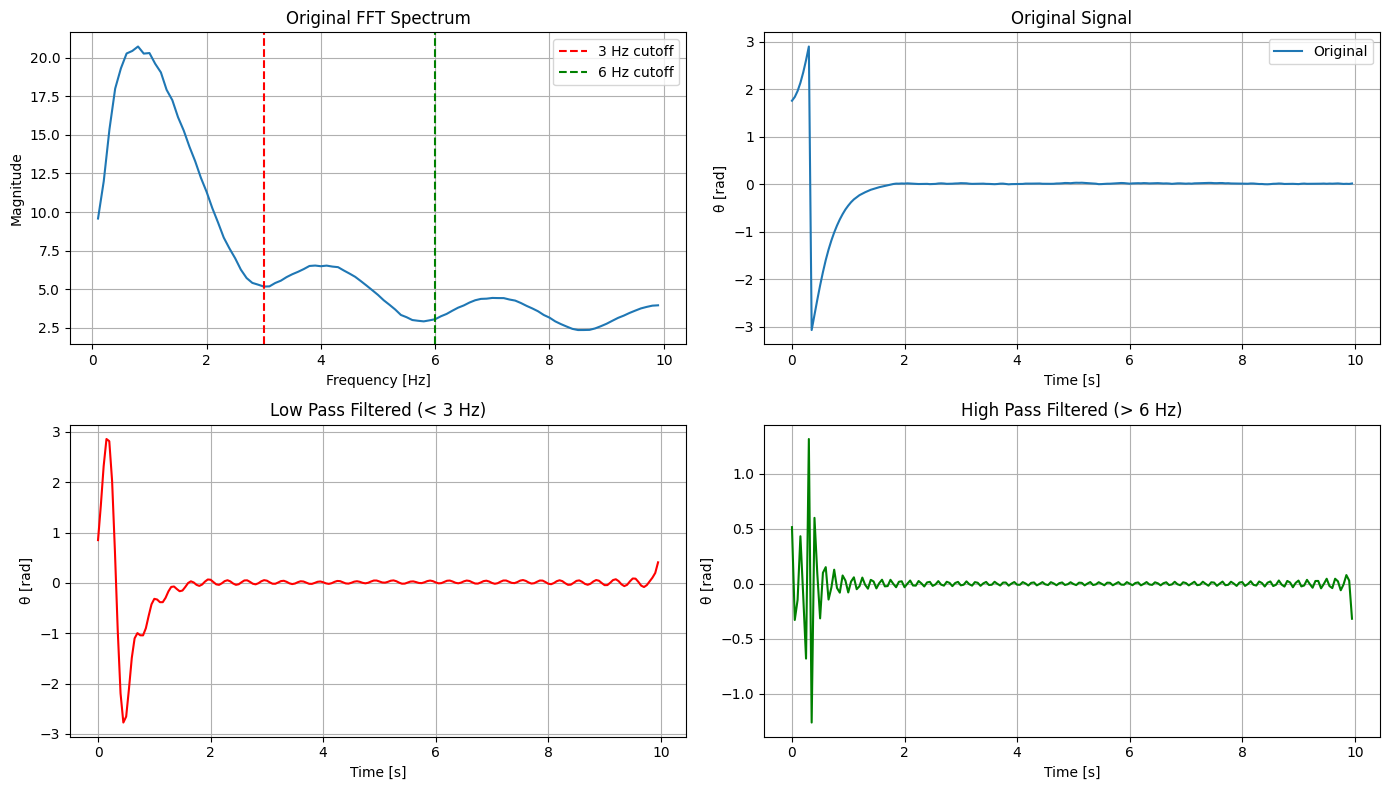

In [13]:
# Extract theta from states_before and compute FFT
states_before_array = np.array(states_before)
theta = np.arctan2(states_before_array[:,1], states_before_array[:,0])

# FFT parameters
dt = env.unwrapped.dt  # Pendulum timestep
N = len(theta)
theta_fft = np.fft.fft(theta)
freqs = np.fft.fftfreq(N, d=dt)

lpf = 3
hpf = 6

# Apply low pass filter at 3 Hz
theta_fft_lowpass = theta_fft.copy()
theta_fft_lowpass[np.abs(freqs) > lpf] = 0
theta_lowpass = np.fft.ifft(theta_fft_lowpass).real

# Apply high pass filter at 6 Hz
theta_fft_highpass = theta_fft.copy()
theta_fft_highpass[np.abs(freqs) < hpf] = 0
theta_highpass = np.fft.ifft(theta_fft_highpass).real

# Use only positive frequencies for plotting
mask = freqs > 0

# Plot FFT magnitude and filtered signals
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Original FFT
axes[0, 0].plot(freqs[mask], np.abs(theta_fft[mask]))
axes[0, 0].axvline(lpf, color='r', linestyle='--', label=f'{lpf} Hz cutoff')
axes[0, 0].axvline(hpf, color='g', linestyle='--', label=f'{hpf} Hz cutoff')
axes[0, 0].set_xlabel("Frequency [Hz]")
axes[0, 0].set_ylabel("Magnitude")
axes[0, 0].set_title("Original FFT Spectrum")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Original signal
time = np.arange(N) * dt
axes[0, 1].plot(time, theta, label='Original')
axes[0, 1].set_xlabel("Time [s]")
axes[0, 1].set_ylabel("θ [rad]")
axes[0, 1].set_title("Original Signal")
axes[0, 1].legend()
axes[0, 1].grid(True)

# Low pass filtered
axes[1, 0].plot(time, theta_lowpass, color='red')
axes[1, 0].set_xlabel("Time [s]")
axes[1, 0].set_ylabel("θ [rad]")
axes[1, 0].set_title(f"Low Pass Filtered (< {lpf} Hz)")
axes[1, 0].grid(True)

# High pass filtered
axes[1, 1].plot(time, theta_highpass, color='green')
axes[1, 1].set_xlabel("Time [s]")
axes[1, 1].set_ylabel("θ [rad]")
axes[1, 1].set_title(f"High Pass Filtered (> {hpf} Hz)")
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [14]:
# Energy = sum of squared magnitudes

# Band 1: 0 to  lpf Hz
mask_band1 = np.abs(freqs) <= lpf
energy_band1 = np.sum(np.abs(theta_fft[mask_band1])**2)

# Band 2: lpf to hpf Hz
mask_band2 = (np.abs(freqs) > lpf) & (np.abs(freqs) <= hpf)
energy_band2 = np.sum(np.abs(theta_fft[mask_band2])**2)

# Band 3: hpf Hz and above
mask_band3 = np.abs(freqs) > hpf    
energy_band3 = np.sum(np.abs(theta_fft[mask_band3])**2)

# Total energy
total_energy = energy_band1 + energy_band2 + energy_band3

print(f"Energy Distribution:")
print(f"  Band 1 (0-{lpf} Hz):   {energy_band1:.2f} ({100*energy_band1/total_energy:.1f}%)")
print(f"  Band 2 ({lpf}-{hpf} Hz):   {energy_band2:.2f} ({100*energy_band2/total_energy:.1f}%)")
print(f"  Band 3 (>{hpf} Hz):    {energy_band3:.2f} ({100*energy_band3/total_energy:.1f}%)")
print(f"  Total:             {total_energy:.2f}")



Energy Distribution:
  Band 1 (0-3 Hz):   12604.71 (82.7%)
  Band 2 (3-6 Hz):   1625.18 (10.7%)
  Band 3 (>6 Hz):    1007.72 (6.6%)
  Total:             15237.60


In [15]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

print(sigmoid(energy_band1/total_energy))
print(sigmoid(energy_band2/total_energy))
print(sigmoid(energy_band3/total_energy))

0.69576484
0.5266387
0.51652735


# 2.1 With Filter

Penalizes high frequency actions by comparing itself with a LPF version of itself. Also penalises high angular velocity. 

In [ ]:
from scipy.signal import butter, lfilter, lfilter_zi
import numpy as np
import gymnasium as gym

class BandLimitedRewardWrapper(gym.Wrapper):
    def __init__(
        self,
        env,
        fs=20.0, # sampling frequency of Pendulum-v1 = 1/0.05s
        cutoff_hz=6.0,
        lambda_lpf=0.1, 
        lambda_w=0.01
    ):
        super().__init__(env)

        self.lambda_lpf = lambda_lpf
        self.lambda_w = lambda_w

        nyq = 0.5 * fs
        self.b, self.a = butter(2, cutoff_hz / nyq, btype="low")
        self.zi = lfilter_zi(self.b, self.a)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.zi = lfilter_zi(self.b, self.a)
        return obs, info

    def step(self, action):
        # ---- action handling (CRITICAL) ----
        u = float(action)                     # scalar for filtering
        action_env = np.array([u], dtype=np.float32)  # shape (1,) for Pendulum

        obs, reward, terminated, truncated, info = self.env.step(action_env)

        # ---- LPF reference (scalar-safe) ----
        u_lpf, self.zi = lfilter(self.b, self.a, [u], zi=self.zi)
        u_lpf = u_lpf[0]

        # ---- penalties ----
        band_penalty = -self.lambda_lpf * (u - u_lpf)**2

        _, _, theta_dot = obs
        vel_penalty = -self.lambda_w * theta_dot**2

        reward += band_penalty + vel_penalty

        return obs, reward, terminated, truncated, info


## 2.2 Training

In [16]:
env_smooth = BandLimitedRewardWrapper(
    gym.make("Pendulum-v1"),
    cutoff_hz=6.0,
    lambda_lpf=0.1,
    lambda_w=0.01
)


actor_smooth = Actor(obs_dim, act_dim).to(device)
critic1_smooth = Critic(obs_dim, act_dim).to(device)
critic2_smooth = Critic(obs_dim, act_dim).to(device)
target1_smooth = Critic(obs_dim, act_dim).to(device)
target2_smooth = Critic(obs_dim, act_dim).to(device)

target1_smooth.load_state_dict(critic1_smooth.state_dict())
target2_smooth.load_state_dict(critic2_smooth.state_dict())

actor_optim_smooth = optim.Adam(actor_smooth.parameters(), lr=3e-4)
critic_optim_smooth = optim.Adam(
    list(critic1_smooth.parameters()) + list(critic2_smooth.parameters()), lr=3e-4
)

buffer_smooth = ReplayBuffer()


In [17]:
state, _ = env_smooth.reset()

for step in range(30_000):

    with torch.no_grad():
        s = torch.FloatTensor(state).unsqueeze(0).to(device)
        a, _ = actor_smooth.sample(s)
        action = (a * act_limit).cpu().numpy()[0]

    next_state, reward, terminated, truncated, _ = env_smooth.step(action)
    done = terminated or truncated

    buffer_smooth.push(state, action, reward, next_state, done)
    state = next_state

    if done:
        state, _ = env_smooth.reset()

    if len(buffer_smooth) < 256:
        continue

    states, actions, rewards, next_states, dones = buffer_smooth.sample(256)

    with torch.no_grad():
        next_actions, logp = actor_smooth.sample(next_states)
        next_actions = next_actions * act_limit
        q1_t = target1_smooth(next_states, next_actions)
        q2_t = target2_smooth(next_states, next_actions)
        q_target = rewards + gamma * (1 - dones) * (torch.min(q1_t, q2_t) - alpha * logp)

    q1 = critic1_smooth(states, actions)
    q2 = critic2_smooth(states, actions)
    critic_loss = ((q1 - q_target)**2 + (q2 - q_target)**2).mean()

    critic_optim_smooth.zero_grad()
    critic_loss.backward()
    critic_optim_smooth.step()

    actions_new, logp = actor_smooth.sample(states)
    actions_new = actions_new * act_limit
    q1_new = critic1_smooth(states, actions_new)
    q2_new = critic2_smooth(states, actions_new)
    actor_loss = (alpha * logp - torch.min(q1_new, q2_new)).mean()

    actor_optim_smooth.zero_grad()
    actor_loss.backward()
    actor_optim_smooth.step()

    for t, s in zip(target1_smooth.parameters(), critic1_smooth.parameters()):
        t.data.copy_(tau * s.data + (1 - tau) * t.data)

    for t, s in zip(target2_smooth.parameters(), critic2_smooth.parameters()):
        t.data.copy_(tau * s.data + (1 - tau) * t.data)
        
    if step % 5000 == 0:
        print(f"Step {step}")


/tmp/ipykernel_3828404/1122265786.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u = float(action)                     # scalar for filtering


Step 5000


Step 10000


Step 15000


Step 20000


Step 25000


In [18]:
env_eval = gym.make("Pendulum-v1")
state, _ = env_eval.reset(seed=42)
done = False
state_vars_smooth = []

while not done:
    with torch.no_grad():
        s = torch.FloatTensor(state).unsqueeze(0).to(device)
        action, _ = actor_smooth.sample(s)
        action = (action * act_limit).cpu().numpy()[0]

    state, _, terminated, truncated, _ = env_eval.step(action)
    state_vars_smooth.append(state)
    done = terminated or truncated

env_eval.close()


## 2.3 FFT analysis

In [19]:
state_vars_smooth = np.array(state_vars_smooth)
theta_smooth = np.arctan2(state_vars_smooth[:,1], state_vars_smooth[:,0])

theta_fft_smooth = np.fft.fft(theta_smooth)
freqs_smooth = np.fft.fftfreq(len(theta_smooth), d=dt)


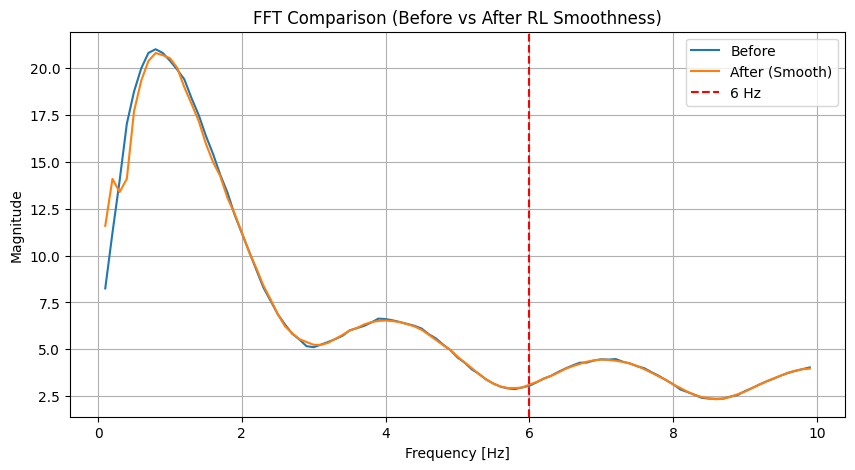

In [20]:
mask = freqs > 0

plt.figure(figsize=(10,5))
plt.plot(freqs[mask], np.abs(theta_fft[mask]), label="Before")
plt.plot(freqs_smooth[mask], np.abs(theta_fft_smooth[mask]), label="After (Smooth)")
plt.axvline(hpf, color="r", linestyle="--", label="6 Hz")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.title("FFT Comparison (Before vs After RL Smoothness)")
plt.legend()
plt.grid(True)
plt.show()


In [21]:


# Rollout smooth / band-limited agent
actions_after, states_after = rollout_actions(
    env_eval, actor_smooth, act_limit, device, seed=42
)

env_eval.close()


In [22]:
dt = env_eval.unwrapped.dt  # Pendulum timestep
N_before = len(actions_before)
N_after = len(actions_after)

fft_before = np.fft.fft(actions_before)
fft_after = np.fft.fft(actions_after)

freqs_before = np.fft.fftfreq(N_before, d=dt)
freqs_after = np.fft.fftfreq(N_after, d=dt)


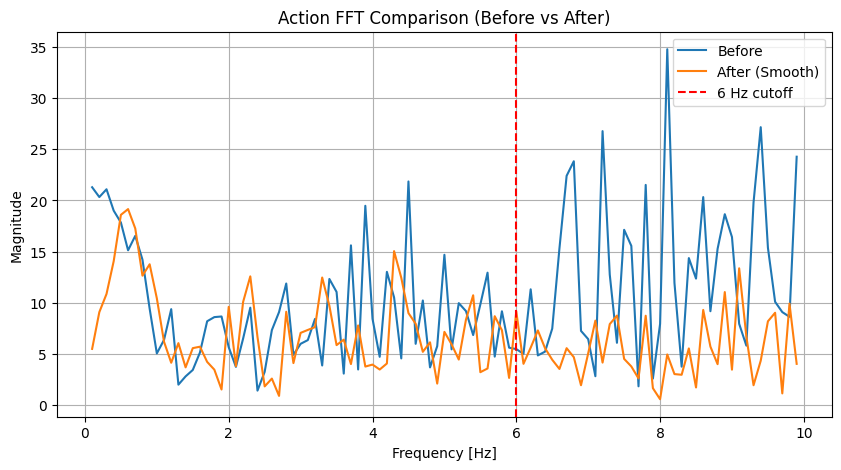

In [23]:
mask_b = freqs_before > 0
mask_a = freqs_after > 0

plt.figure(figsize=(10, 5))
plt.plot(freqs_before[mask_b], np.abs(fft_before[mask_b]), label="Before")
plt.plot(freqs_after[mask_a], np.abs(fft_after[mask_a]), label="After (Smooth)")
plt.axvline(6.0, color="r", linestyle="--", label="6 Hz cutoff")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.title("Action FFT Comparison (Before vs After)")
plt.legend()
plt.grid(True)
plt.show()


# 3.1 Action LPF

A LPF for 6 Hz is applied on the action. The env never sees action > 6 Hz. 

In [24]:
from scipy.signal import butter, lfilter, lfilter_zi
import numpy as np
import gymnasium as gym

class ActionLPFWrapper(gym.Wrapper):
    def __init__(self, env, fs=20.0, cutoff_hz=6.0):
        super().__init__(env)

        nyq = 0.5 * fs
        self.b, self.a = butter(2, cutoff_hz / nyq, btype="low")
        self.zi = lfilter_zi(self.b, self.a)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.zi = lfilter_zi(self.b, self.a)
        return obs, info

    def step(self, action):
        # action shape: (1,)
        u = float(action[0])

        # filter scalar action
        u_filt, self.zi = lfilter(self.b, self.a, [u], zi=self.zi)
        u_filt = u_filt[0]

        action_env = np.array([u_filt], dtype=np.float32)
        return self.env.step(action_env)


In [25]:
env_lpf = ActionLPFWrapper(
    gym.make("Pendulum-v1"),
    cutoff_hz=6.0
)

actor_lpf = Actor(obs_dim, act_dim).to(device)
critic1_lpf = Critic(obs_dim, act_dim).to(device)
critic2_lpf = Critic(obs_dim, act_dim).to(device)
target1_lpf = Critic(obs_dim, act_dim).to(device)
target2_lpf = Critic(obs_dim, act_dim).to(device)

target1_lpf.load_state_dict(critic1_lpf.state_dict())
target2_lpf.load_state_dict(critic2_lpf.state_dict())

actor_optim_lpf = optim.Adam(actor_lpf.parameters(), lr=3e-4)
critic_optim_lpf = optim.Adam(
    list(critic1_lpf.parameters()) + list(critic2_lpf.parameters()), lr=3e-4
)

buffer_lpf = ReplayBuffer()

## 3.2 Training

In [26]:
state, _ = env_lpf.reset()

for step in range(30_000):

    # -------- Action selection --------
    with torch.no_grad():
        s = torch.FloatTensor(state).unsqueeze(0).to(device)
        a, _ = actor_lpf.sample(s)
        action = (a * act_limit).cpu().numpy()[0]  # shape (1,)

    next_state, reward, terminated, truncated, _ = env_lpf.step(action)
    done = terminated or truncated

    buffer_lpf.push(state, action, reward, next_state, done)
    state = next_state

    if done:
        state, _ = env_lpf.reset()

    if len(buffer_lpf) < 256:
        continue

    # -------- Sample batch --------
    states, actions, rewards, next_states, dones = buffer_lpf.sample(256)

    # -------- Critic update --------
    with torch.no_grad():
        next_actions, logp = actor_lpf.sample(next_states)
        next_actions = next_actions * act_limit   # ❗ NOT in-place
        q1_t = target1_lpf(next_states, next_actions)
        q2_t = target2_lpf(next_states, next_actions)
        q_target = rewards + gamma * (1 - dones) * (
            torch.min(q1_t, q2_t) - alpha * logp
        )

    q1 = critic1_lpf(states, actions)
    q2 = critic2_lpf(states, actions)
    critic_loss = ((q1 - q_target)**2 + (q2 - q_target)**2).mean()

    critic_optim_lpf.zero_grad()
    critic_loss.backward()
    critic_optim_lpf.step()

    # -------- Actor update --------
    actions_new, logp = actor_lpf.sample(states)
    actions_new = actions_new * act_limit   # ❗ NOT in-place
    q1_new = critic1_lpf(states, actions_new)
    q2_new = critic2_lpf(states, actions_new)

    actor_loss = (alpha * logp - torch.min(q1_new, q2_new)).mean()

    actor_optim_lpf.zero_grad()
    actor_loss.backward()
    actor_optim_lpf.step()

    # -------- Target networks --------
    for t, s in zip(target1_lpf.parameters(), critic1_lpf.parameters()):
        t.data.copy_(tau * s.data + (1 - tau) * t.data)

    for t, s in zip(target2_lpf.parameters(), critic2_lpf.parameters()):
        t.data.copy_(tau * s.data + (1 - tau) * t.data)

    if step % 5000 == 0:
        print(f"Step {step}")


Step 5000


Step 10000


Step 15000


Step 20000


Step 25000


## 3.3 FFT analysis

In [27]:
env_eval_lpf = ActionLPFWrapper(
    gym.make("Pendulum-v1"),
    cutoff_hz=6.0
)

actions_lpf, states_lpf = rollout_actions(
    env_eval_lpf, actor_lpf, act_limit, device
)

env_eval_lpf.close()

In [28]:
dt = env_eval_lpf.unwrapped.dt

fft_lpf = np.fft.fft(actions_lpf)
freqs_lpf = np.fft.fftfreq(len(actions_lpf), d=dt)

mask = freqs_lpf > 0


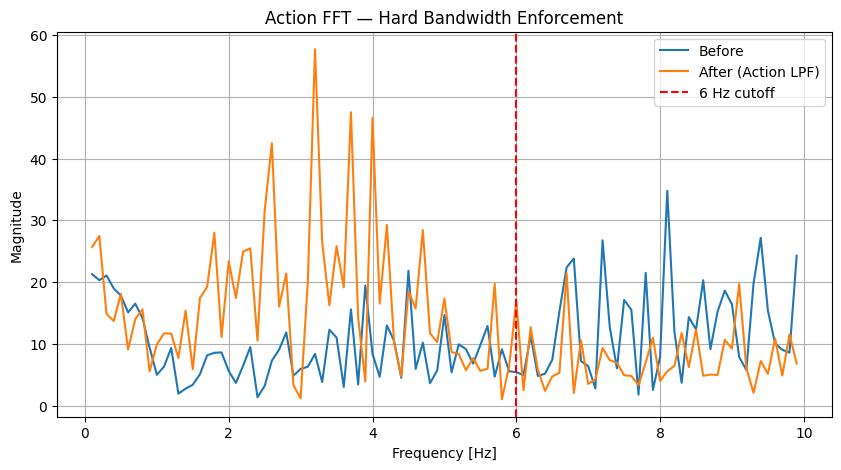

In [29]:
plt.figure(figsize=(10,5))
plt.plot(freqs_before[mask_b], np.abs(fft_before[mask_b]), label="Before")
plt.plot(freqs_lpf[mask], np.abs(fft_lpf[mask]), label="After (Action LPF)")
plt.axvline(6.0, color="r", linestyle="--", label="6 Hz cutoff")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.title("Action FFT — Hard Bandwidth Enforcement")
plt.legend()
plt.grid(True)
plt.show()


In [30]:

def hf_energy_ratio(fft, freqs, cutoff):
    hf = np.abs(freqs) > cutoff
    return np.sum(np.abs(fft[hf])**2) / np.sum(np.abs(fft)**2)

print("HF Energy (>6 Hz):")
print(f"Before : {100*hf_energy_ratio(fft_before, freqs_before, 6):.2f}%")
print(f"LPF    : {100*hf_energy_ratio(fft_lpf, freqs_lpf, 6):.2f}%")


HF Energy (>6 Hz):
Before : 54.49%
LPF    : 9.52%


# 4. Comparision of all 3 approaches

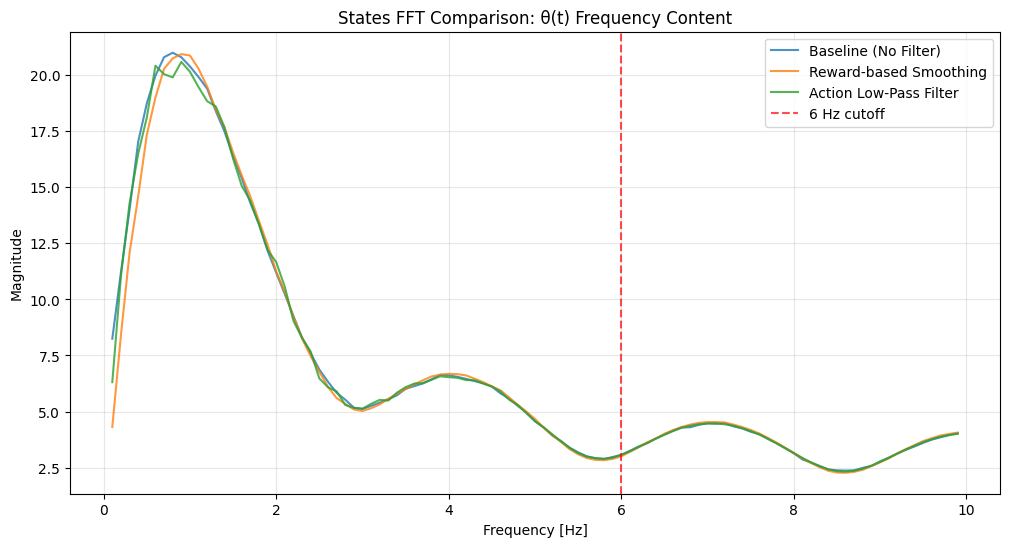

High Frequency Energy (>6 Hz) in States:
Baseline:              6.63%
Reward-based Smoothing: 6.49%
Action LPF:            6.77%


In [31]:
# Compare states FFT of all three methods
# Extract theta from all three state arrays
theta_baseline = np.arctan2(states_before[:, 1], states_before[:, 0])
theta_reward_smooth = np.arctan2(states_after[:, 1], states_after[:, 0])  
theta_action_lpf = np.arctan2(states_lpf[:, 1], states_lpf[:, 0])

# Compute FFT for each method
fft_baseline = np.fft.fft(theta_baseline)
fft_reward_smooth = np.fft.fft(theta_reward_smooth)
fft_action_lpf = np.fft.fft(theta_action_lpf)

# Generate frequency arrays
dt = env.unwrapped.dt
freqs_baseline = np.fft.fftfreq(len(theta_baseline), d=dt)
freqs_reward_smooth = np.fft.fftfreq(len(theta_reward_smooth), d=dt)
freqs_action_lpf = np.fft.fftfreq(len(theta_action_lpf), d=dt)

# Plot comparison of states FFT
mask_baseline = freqs_baseline > 0
mask_reward_smooth = freqs_reward_smooth > 0
mask_action_lpf = freqs_action_lpf > 0

plt.figure(figsize=(12, 6))
plt.plot(freqs_baseline[mask_baseline], np.abs(fft_baseline[mask_baseline]), 
         label="Baseline (No Filter)", alpha=0.8)
plt.plot(freqs_reward_smooth[mask_reward_smooth], np.abs(fft_reward_smooth[mask_reward_smooth]), 
         label="Reward-based Smoothing", alpha=0.8)
plt.plot(freqs_action_lpf[mask_action_lpf], np.abs(fft_action_lpf[mask_action_lpf]), 
         label="Action Low-Pass Filter", alpha=0.8)

plt.axvline(6.0, color="r", linestyle="--", label="6 Hz cutoff", alpha=0.7)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.title("States FFT Comparison: θ(t) Frequency Content")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate and display energy ratios for each method
def calculate_hf_energy_ratio(fft_signal, freqs, cutoff=6.0):
    hf_mask = np.abs(freqs) > cutoff
    total_energy = np.sum(np.abs(fft_signal)**2)
    hf_energy = np.sum(np.abs(fft_signal[hf_mask])**2)
    return hf_energy / total_energy if total_energy > 0 else 0

hf_ratio_baseline = calculate_hf_energy_ratio(fft_baseline, freqs_baseline)
hf_ratio_reward = calculate_hf_energy_ratio(fft_reward_smooth, freqs_reward_smooth)
hf_ratio_action_lpf = calculate_hf_energy_ratio(fft_action_lpf, freqs_action_lpf)

print("High Frequency Energy (>6 Hz) in States:")
print(f"Baseline:              {100*hf_ratio_baseline:.2f}%")
print(f"Reward-based Smoothing: {100*hf_ratio_reward:.2f}%")
print(f"Action LPF:            {100*hf_ratio_action_lpf:.2f}%")

In [32]:
100 * (hf_ratio_action_lpf - hf_ratio_baseline) / hf_ratio_baseline

np.float32(2.1252413)

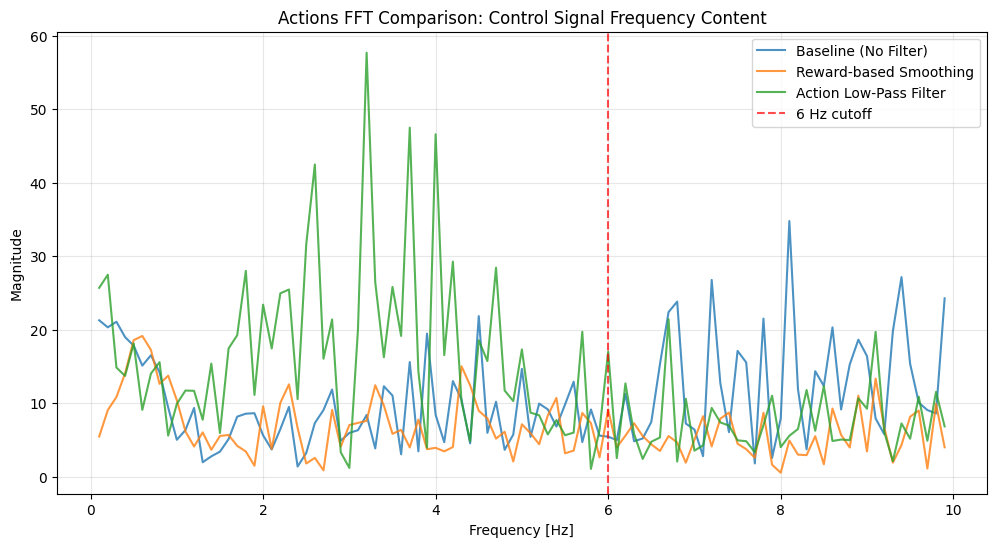

High Frequency Energy (>6 Hz) in Actions:
Baseline:              54.49%
Reward-based Smoothing: 7.77%
Action LPF:            9.52%

HF Energy Reduction vs Baseline:
Reward-based Smoothing: 85.7% reduction
Action LPF:            82.5% reduction


In [33]:
# Compare actions FFT of all three methods
mask_baseline = freqs_before > 0
mask_reward_smooth = freqs_after > 0
mask_action_lpf = freqs_lpf > 0

plt.figure(figsize=(12, 6))
plt.plot(freqs_before[mask_baseline], np.abs(fft_before[mask_baseline]), 
         label="Baseline (No Filter)", alpha=0.8)
plt.plot(freqs_after[mask_reward_smooth], np.abs(fft_after[mask_reward_smooth]), 
         label="Reward-based Smoothing", alpha=0.8)
plt.plot(freqs_lpf[mask_action_lpf], np.abs(fft_lpf[mask_action_lpf]), 
         label="Action Low-Pass Filter", alpha=0.8)

plt.axvline(6.0, color="r", linestyle="--", label="6 Hz cutoff", alpha=0.7)
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.title("Actions FFT Comparison: Control Signal Frequency Content")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate and display high frequency energy ratios for actions
hf_ratio_actions_baseline = hf_energy_ratio(fft_before, freqs_before, 6.0)
hf_ratio_actions_reward = hf_energy_ratio(fft_after, freqs_after, 6.0)
hf_ratio_actions_lpf = hf_energy_ratio(fft_lpf, freqs_lpf, 6.0)

print("High Frequency Energy (>6 Hz) in Actions:")
print(f"Baseline:              {100*hf_ratio_actions_baseline:.2f}%")
print(f"Reward-based Smoothing: {100*hf_ratio_actions_reward:.2f}%")
print(f"Action LPF:            {100*hf_ratio_actions_lpf:.2f}%")

# Calculate percentage reduction in HF energy
reduction_reward = 100 * (hf_ratio_actions_baseline - hf_ratio_actions_reward) / hf_ratio_actions_baseline
reduction_lpf = 100 * (hf_ratio_actions_baseline - hf_ratio_actions_lpf) / hf_ratio_actions_baseline

print(f"\nHF Energy Reduction vs Baseline:")
print(f"Reward-based Smoothing: {reduction_reward:.1f}% reduction")
print(f"Action LPF:            {reduction_lpf:.1f}% reduction")